<a href="https://colab.research.google.com/github/ivolake/2021sem9_ml_labs/blob/main/CGZ_LW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://slides.com/romvano/lab2/fullscreen

In [ ]:
1+1

2

In [ ]:
from collections import Counter
import pickle
import operator as op

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.core.pylabtools import figsize
import plotly.express as px
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import iplot, init_notebook_mode

# figsize(8, 8) # зададим размер картинки
init_notebook_mode(connected=True)
pio.renderers.default='notebook'


from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, ShuffleSplit, StratifiedShuffleSplit, LeaveOneOut, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score, \
                            precision_score, recall_score, \
                            precision_recall_curve, roc_auc_score, f1_score, \
                            fbeta_score, auc, \
                            make_scorer

from sklearn.tree import export_graphviz

# import os
# from glob import glob

from google.colab import drive


In [ ]:
drive.mount ('/content/drive')


Mounted at /content/drive


Импорт библиотек, подключение диска

In [ ]:
my_path = '/content/drive/MyDrive/drive' # '/content/drive/MyDrive/data'

In [ ]:
df = pd.read_csv(f'{my_path}/voice.csv')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3168 entries, 0 to 3167
Data columns (total 21 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   meanfreq  3168 non-null   float64
 1   sd        3168 non-null   float64
 2   median    3168 non-null   float64
 3   Q25       3168 non-null   float64
 4   Q75       3168 non-null   float64
 5   IQR       3168 non-null   float64
 6   skew      3168 non-null   float64
 7   kurt      3168 non-null   float64
 8   sp.ent    3168 non-null   float64
 9   sfm       3168 non-null   float64
 10  mode      3168 non-null   float64
 11  centroid  3168 non-null   float64
 12  meanfun   3168 non-null   float64
 13  minfun    3168 non-null   float64
 14  maxfun    3168 non-null   float64
 15  meandom   3168 non-null   float64
 16  mindom    3168 non-null   float64
 17  maxdom    3168 non-null   float64
 18  dfrange   3168 non-null   float64
 19  modindx   3168 non-null   float64
 20  label     3168 non-null   obje

In [ ]:
df.describe()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx
count,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000,3168.000000
mean,0.180907,0.057126,0.185621,0.140456,0.224765,0.084309,3.140168,36.568461,0.895127,0.408216,0.165282,0.180907,0.142807,0.036802,0.258842,0.829211,0.052647,5.047277,4.994630,0.173752
std,0.029918,0.016652,0.036360,0.048680,0.023639,0.042783,4.240529,134.928661,0.044980,0.177521,0.077203,0.029918,0.032304,0.019220,0.030077,0.525205,0.063299,3.521157,3.520039,0.119454
min,0.039363,0.018363,0.010975,0.000229,0.042946,0.014558,0.141735,2.068455,0.738651,0.036876,0.000000,0.039363,0.055565,0.009775,0.103093,0.007812,0.004883,0.007812,0.000000,0.000000
25%,0.163662,0.041954,0.169593,0.111087,0.208747,0.042560,1.649569,5.669547,0.861811,0.258041,0.118016,0.163662,0.116998,0.018223,0.253968,0.419828,0.007812,2.070312,2.044922,0.099766
50%,0.184838,0.059155,0.190032,0.140286,0.225684,0.094280,2.197101,8.318463,0.901767,0.396335,0.186599,0.184838,0.140519,0.046110,0.271186,0.765795,0.023438,4.992188,4.945312,0.139357
75%,0.199146,0.067020,0.210618,0.175939,0.243660,0.114175,2.931694,13.648905,0.928713,0.533676,0.221104,0.199146,0.169581,0.047904,0.277457,1.177166,0.070312,7.007812,6.992188,0.209183
max,0.251124,0.115273,0.261224,0.247347,0.273469,0.252225,34.725453,1309.612887,0.981997,0.842936,0.280000,0.251124,0.237636,0.204082,0.279114,2.957682,0.458984,21.867188,21.843750,0.932374


In [ ]:
df.head()

,meanfreq,sd,median,Q25,Q75,IQR,skew,kurt,sp.ent,sfm,mode,centroid,meanfun,minfun,maxfun,meandom,mindom,maxdom,dfrange,modindx,label
0,0.059781,0.064241,0.032027,0.015071,0.090193,0.075122,12.863462,274.402906,0.893369,0.491918,0.000000,0.059781,0.084279,0.015702,0.275862,0.007812,0.007812,0.007812,0.000000,0.000000,male
1,0.066009,0.067310,0.040229,0.019414,0.092666,0.073252,22.423285,634.613855,0.892193,0.513724,0.000000,0.066009,0.107937,0.015826,0.250000,0.009014,0.007812,0.054688,0.046875,0.052632,male
2,0.077316,0.083829,0.036718,0.008701,0.131908,0.123207,30.757155,1024.927705,0.846389,0.478905,0.000000,0.077316,0.098706,0.015656,0.271186,0.007990,0.007812,0.015625,0.007812,0.046512,male
3,0.151228,0.072111,0.158011,0.096582,0.207955,0.111374,1.232831,4.177296,0.963322,0.727232,0.083878,0.151228,0.088965,0.017798,0.250000,0.201497,0.007812,0.562500,0.554688,0.247119,male
4,0.135120,0.079146,0.124656,0.078720,0.206045,0.127325,1.101174,4.333713,0.971955,0.783568,0.104261,0.135120,0.106398,0.016931,0.266667,0.712812,0.007812,5.484375,5.476562,0.208274,male


In [ ]:
feats = list(set(df.columns) - set(['label']))

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[feats], 
                                                    df['label'], 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    stratify=df['label'])

In [ ]:
def filter_meanfun(x):
  if x <= 0.116998:
    return 0
  elif x >0.116998 and x <= 0.140519:
    return 1
  elif x > 0.140519 and x <= 0.169581:
    return 2
  elif x > 0.169581:
    return 3

X_train['meanfun_filtered'] = X_train['meanfun'].apply(lambda x: filter_meanfun(x))
X_test['meanfun_filtered'] = X_test['meanfun'].apply(lambda x: filter_meanfun(x))

In [ ]:
# используем объект класса Counter - удобная штука для подсчета значений в итерируемых объектах из стандартной
# библиотеки python. "Обучим" его на титулах из обучающей выборки, а применим преобразование к обеим
counter = Counter(X_train['meanfun_filtered'])

In [ ]:
counter

Counter({0: 534, 1: 525, 2: 537, 3: 526})

In [ ]:
# # Нам понадобится функция, которая обрабатывает тот случай, когда в тестовой выборке попалось значение, которого
# # не было в обучающей
# def get_count(meanfun_filtered):
#     return counter.get(meanfun_filtered, 0) # возвращаем значение из counter, если оно есть, иначе - 0

# X_train.loc[:, 'meanfun_filtered'] = X_train['meanfun_filtered'].apply(get_count)
# X_test.loc[:, 'meanfun_filtered'] = X_test['meanfun_filtered'].apply(get_count)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



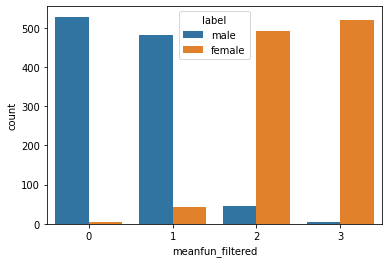

In [ ]:
sns.countplot(X_train['meanfun_filtered'], hue=y_train)

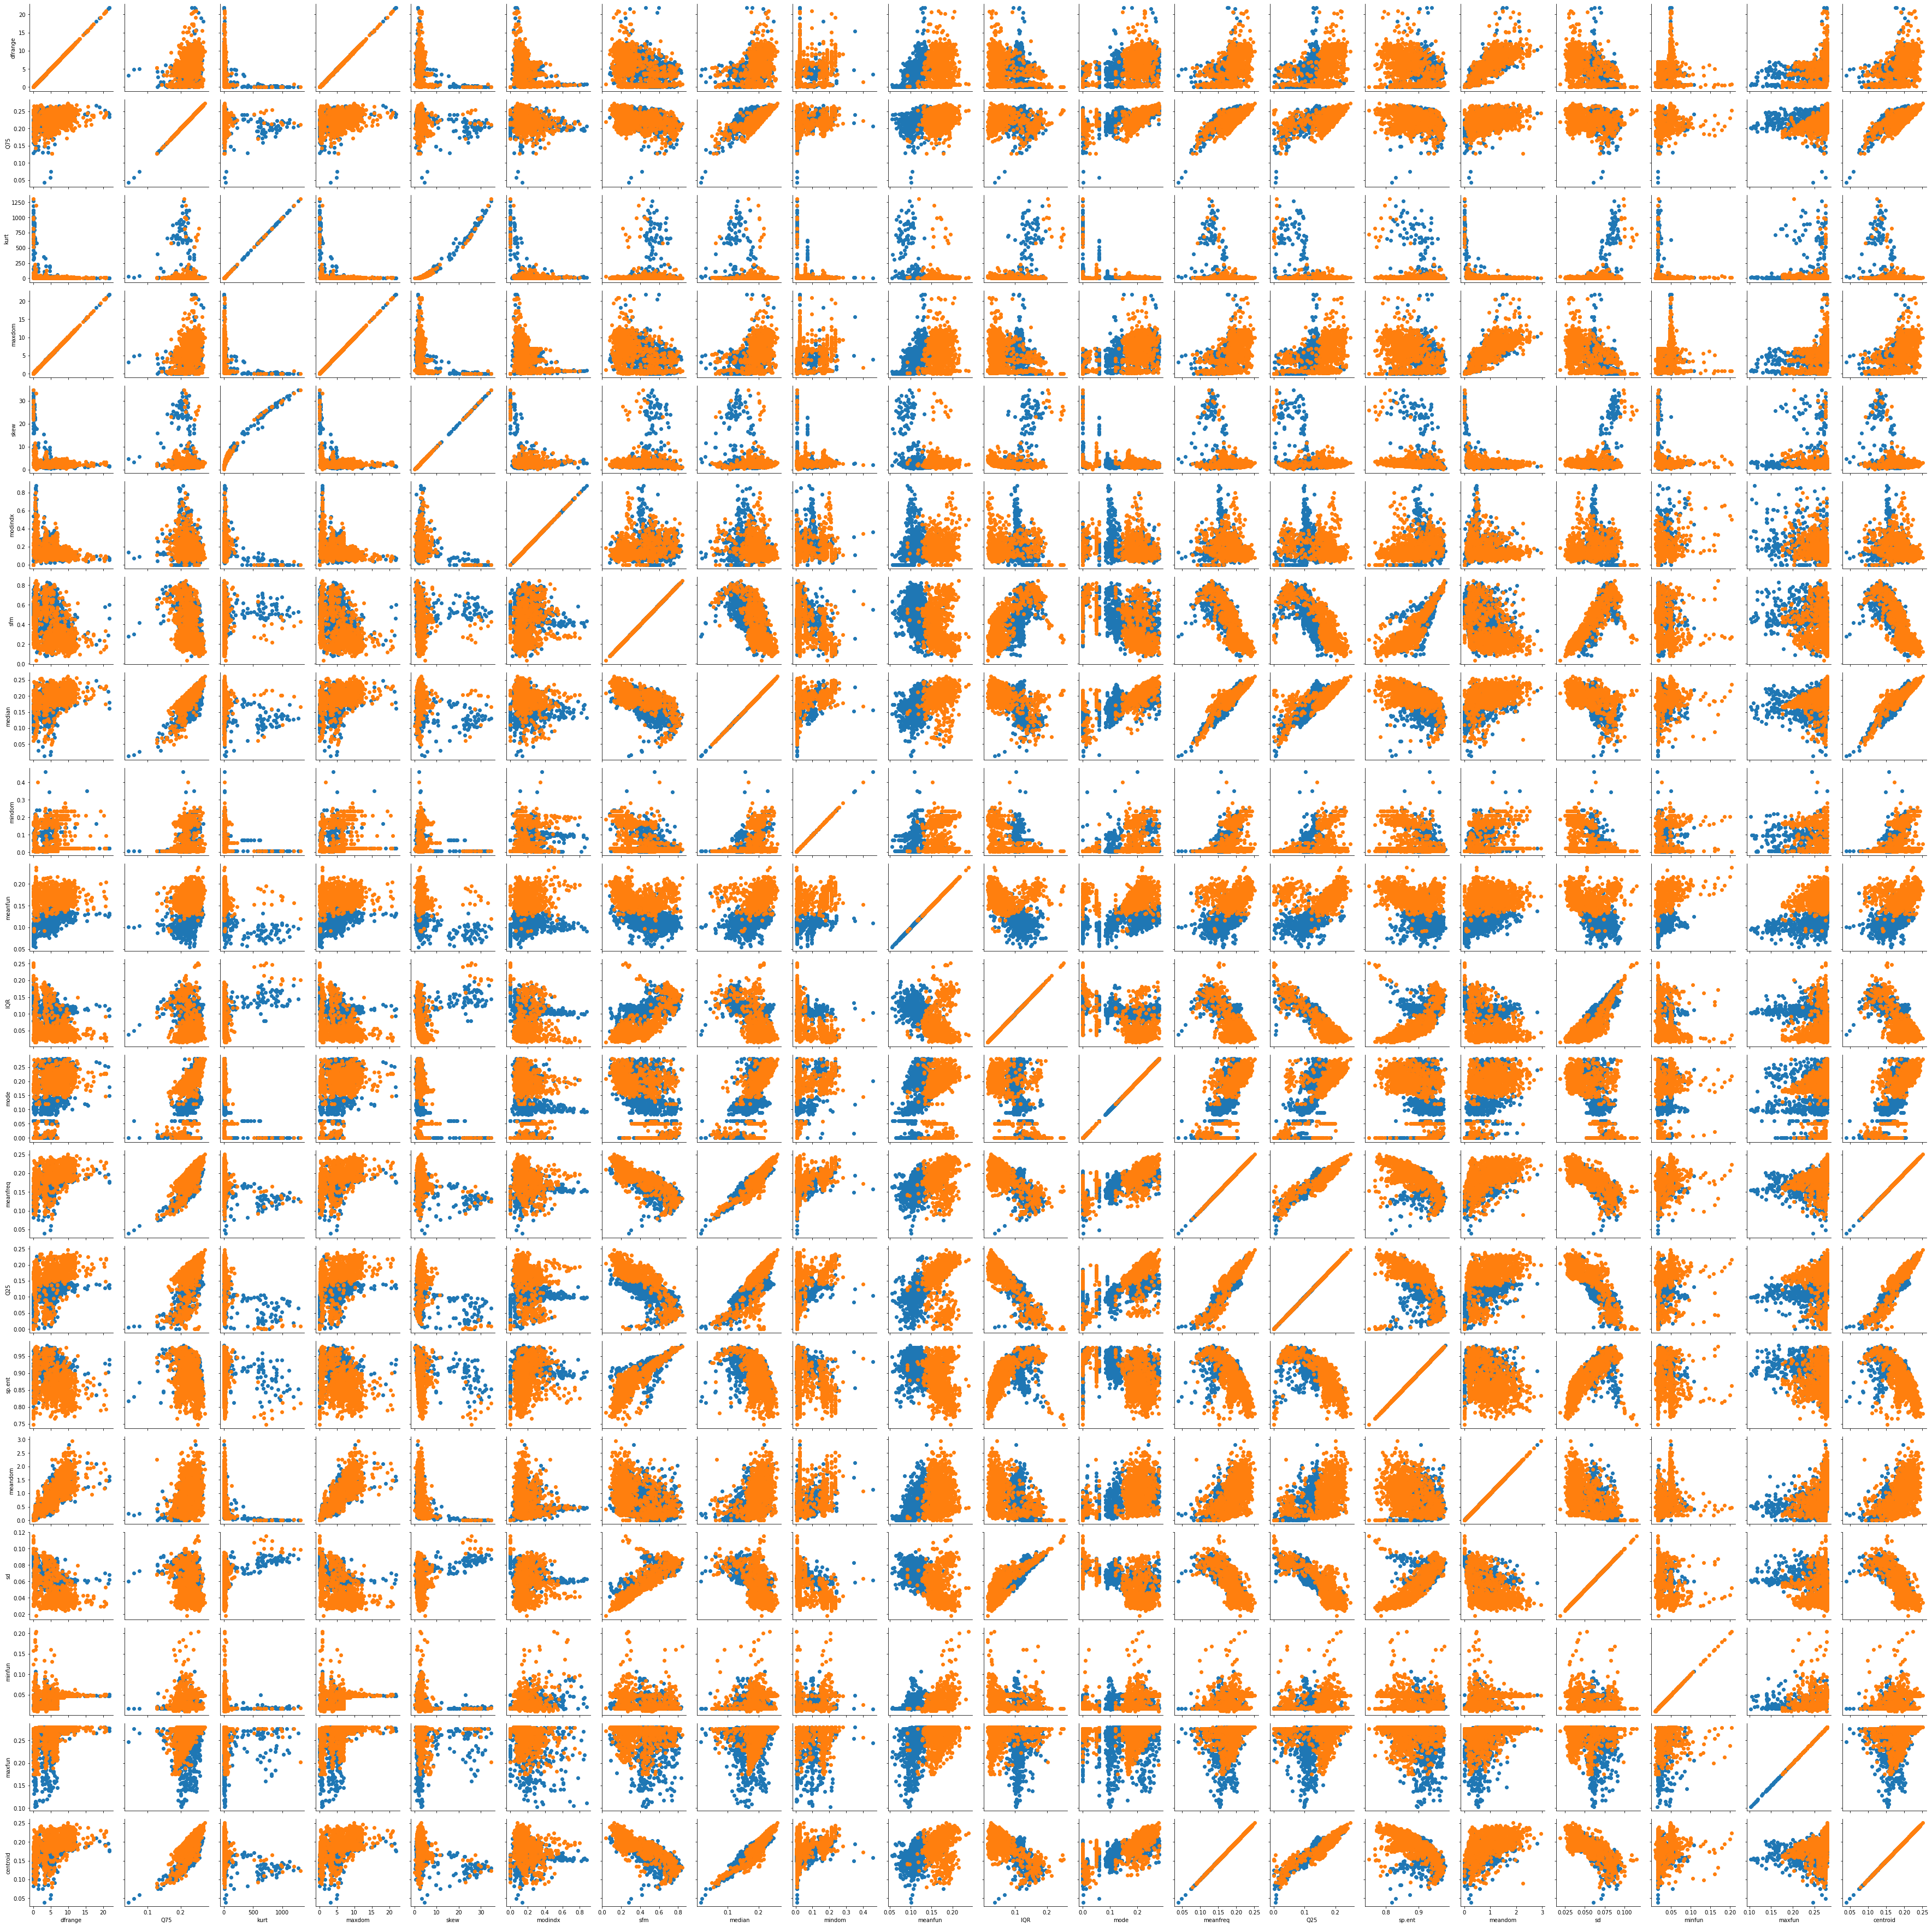

In [ ]:
df_for_pairgrid = X_train.copy()
df_for_pairgrid['target'] = y_train

sns.PairGrid(df_for_pairgrid, hue='target').map(plt.scatter)

Можно видеть, что при помощи признаков `meanfun` и `maxfun` возможно довольно хорошо разделить данные по целевому признаку

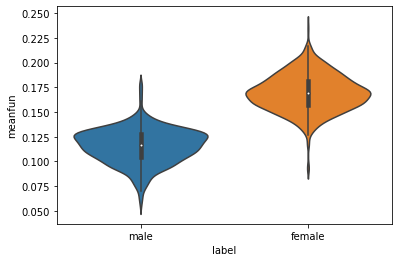

In [ ]:
sns.violinplot(x=y_train, y=X_train['meanfun'])

## Нормализация признаков

In [ ]:
print("Качество алгоритма до нормализации:",
      KNeighborsClassifier(n_neighbors=2).fit(X_train, y_train).score(X_test, y_test))

scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train, ), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_train.columns)

print("Качество алгоритма после нормализации:",
      KNeighborsClassifier(n_neighbors=2).fit(X_train_scaled, y_train).score(X_test_scaled, y_test))


Качество алгоритма до нормализации: 0.7074569789674953
Качество алгоритма после нормализации: 0.9760994263862333


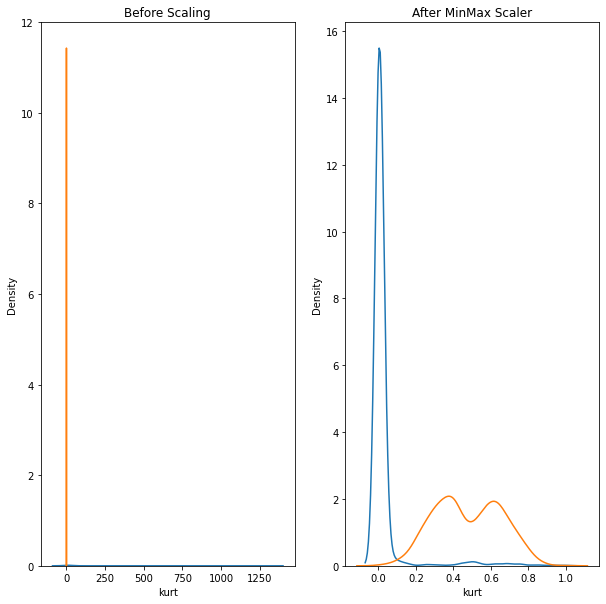

In [ ]:
# графики
fig, (ax1, ax2) = plt.subplots(ncols=2)
ax1.set_title('Before Scaling')
sns.kdeplot(X_train['kurt'], ax=ax1)
sns.kdeplot(X_train['meanfun'], ax=ax1)
ax2.set_title('After MinMax Scaler')
sns.kdeplot(X_train_scaled['kurt'], ax=ax2)
sns.kdeplot(X_train_scaled['meanfun'], ax=ax2)
figsize(15, 15)
plt.show()

## Подбор алгоритма
Не всегда можно понять по визуализации данных, какой алгоритм может хорошо сработать (хотя конкретно в случае этого набора данных выбор очевиден - об этом в следующий раз =) ). Чтобы понять, над какой моделью можно работать, посмотрим на качество на нескольких простых моделях.

In [ ]:
for clf in [DecisionTreeClassifier(), SGDClassifier(), SVC(), GaussianNB(), KNeighborsClassifier()]:
    print(clf.__class__.__name__, clf.fit(X_train_scaled, y_train).score(X_test_scaled, y_test))

DecisionTreeClassifier 0.9636711281070746
SGDClassifier 0.9474187380497132
SVC 0.9789674952198852
GaussianNB 0.884321223709369
KNeighborsClassifier 0.982791586998088


# Метрики качества
Посмотрим на предсказания константного классификатора

In [ ]:
# a_train = np.ones(y_train.shape[0]) # сравним нашу модель с худшей
a_test = np.ones(y_test.shape[0]) # сравним нашу модель с худшей
# y_train_digit = y_train.map({'male': 0, 'female': 1})
y_test_digit = y_test.map({'male': 0, 'female': 1})
# a = sorted(y_test.unique())

In [ ]:
print('Accuracy:', accuracy_score(y_test_digit, a_test))
print('Precision:', precision_score(y_test_digit, a_test, average=None))
print('Recall:', recall_score(y_test_digit, a_test, average=None))
# print('ROC AUC:', roc_auc_score(y_test_digit, a_test, multi_class='ovo'))
# pr, rec, _ = precision_recall_curve(y_test_digit, a_test)
# print('PRC AUC:', auc(rec, pr))
# print('F1:', f1_score(y_test, a))
# print('F0.5:', fbeta_score(y_test, a, 0.5))
# print('F2:', fbeta_score(y_test, a, 2))

Accuracy: 0.5
Precision: [0.  0.5]
Recall: [0. 1.]


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Получили распределение классов в выборке

In [ ]:
print(classification_report(y_test_digit, a_test))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       523
           1       0.50      1.00      0.67       523

    accuracy                           0.50      1046
   macro avg       0.25      0.50      0.33      1046
weighted avg       0.25      0.50      0.33      1046



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



# Препроцессинг и пайплайн

Рассмотрим, как можно подготовить модель и передать ее другому человеку

In [ ]:
pipeline = make_pipeline(
    # FunctionTransformer(dropper, validate=False),                 # добавили удаление признаков в пайплайн;
    #                                                               # параметр validate=False - чтобы функция не пыталась привести все признаки к числам
    # FunctionTransformer(other_transformations, validate=False),   # добавили остальные трансформации признаков
    MinMaxScaler(),                               # нормализацию
    KNeighborsClassifier(n_neighbors=5),          # и сам классификатор с наилучшими параметрами
)

pipeline

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9789674952198852

In [ ]:
with open(f"{my_path}/lab2_model.pickle", 'wb') as opened_file:
    pickle.dump(pipeline, opened_file)

In [ ]:
with open(f"{my_path}/lab2_model.pickle", 'rb') as f:
    model = pickle.load(f)
    
model

Pipeline(steps=[('minmaxscaler', MinMaxScaler()),
                ('kneighborsclassifier', KNeighborsClassifier())])

In [ ]:
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9789674952198852